In [52]:
Alpha_Name = "AlphaNet_Original_Input_10d_return"
start_time = "2020-01-01"
forecast_months = 6 # months
feat_num = 9
sequence = 3

In [53]:
from os import walk
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import torch.utils.data as Data
import torch.optim as optim
from tqdm import tqdm
from torch.autograd import Variable
import time
import multiprocessing as mp
from os import walk
import matplotlib.pyplot as plt
path = '/home/wuwenjun/Data/' + Alpha_Name +'/'
output_path = "/home/wuwenjun/Alpha_Factor/" + "LSTM_" + Alpha_Name + "/result/"
model_dir = "/home/wuwenjun/Alpha_Factor/" + "LSTM_" + Alpha_Name + "/model/"
input_length = feat_num * (feat_num - 1) + 4 * feat_num
if os.path.exists(output_path) == False:
    os.makedirs(output_path)
    print(output_path)

In [54]:
time_list = []
data_path = path + "Final/"
dataframe_list = pd.DataFrame()
for f, _, i in walk(data_path):
    for j in tqdm(i):
        time_list.append(j)
time_list.sort()     
for count,item in enumerate(time_list):
    if item.startswith(start_time):
        train_timestamp = time_list[:count]
        test_timestamp = time_list[count:count + forecast_months//3]
        break
display(train_timestamp)
display(test_timestamp)

model_path = (model_dir + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1]).replace(".par","/")
if os.path.exists(model_path) == False:
    os.makedirs(model_path)
    print(model_path)

100%|██████████| 26/26 [00:00<00:00, 288497.10it/s]


['2015-01-01_2015-03-01.par',
 '2015-03-01_2015-06-01.par',
 '2015-06-01_2015-09-01.par',
 '2015-09-01_2016-01-01.par',
 '2016-01-01_2016-03-01.par',
 '2016-03-01_2016-06-01.par',
 '2016-06-01_2016-09-01.par',
 '2016-09-01_2017-01-01.par',
 '2017-01-01_2017-03-01.par',
 '2017-03-01_2017-06-01.par',
 '2017-06-01_2017-09-01.par',
 '2017-09-01_2018-01-01.par',
 '2018-01-01_2018-03-01.par',
 '2018-03-01_2018-06-01.par',
 '2018-06-01_2018-09-01.par',
 '2018-09-01_2019-01-01.par',
 '2019-01-01_2019-03-01.par',
 '2019-03-01_2019-06-01.par',
 '2019-06-01_2019-09-01.par',
 '2019-09-01_2020-01-01.par']

['2020-01-01_2020-03-01.par', '2020-03-01_2020-06-01.par']

In [55]:
trainx , trainy , testx , testy = [] , [] , [],  []

for train in tqdm(train_timestamp):
    df = pd.read_parquet(path+ "Final/" + train).set_index(["timestamp","ticker"])
    trainx.append(df.drop("target",axis=1))
    trainy.append(df['target'])
trainx = pd.concat(trainx,axis=0)
trainy = pd.concat(trainy,axis=0)

display(trainx)
display(trainy)


for test in tqdm(test_timestamp):
    df = pd.read_parquet(path+ "Final/" + test).set_index(["timestamp","ticker"])
    testx.append(df.drop("target",axis=1))
    testy.append(df['target'])
testx = pd.concat(testx,axis=0)
testy = pd.concat(testy,axis=0)
target_list = pd.DataFrame(testy.copy())
display(testx)
display(testy)

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


,,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2015-02-16 09:30:00,1,1047.509016,165.116922,249.851660,924.464829,243.390500,183.194222,926.891342,158.088300,78.887819,957.587687,...,861850.412364,0.138453,-0.376716,0.284385,1.522075,1.245018,0.876160,3.017927,2.468587,1.737222
2015-02-17 09:30:00,1,1284.106922,304.746632,233.319300,1251.132811,325.347890,190.544389,1311.161194,268.878420,78.529422,1262.525551,...,825372.445636,-1.631951,-0.601635,0.240629,1.601496,1.147820,0.839082,3.175407,2.275878,1.663689
2015-02-25 09:30:00,1,1515.538580,320.840611,242.242430,1522.025569,325.437271,214.401980,1539.154187,259.118036,99.405562,1482.690747,...,784033.056545,-1.377793,-0.151133,0.292173,1.574869,1.078356,0.797058,3.122595,2.138158,1.580369
2015-02-26 09:30:00,1,1466.712161,355.378729,244.332118,1546.573639,318.650776,222.730596,1381.349806,297.507667,108.085628,1469.916341,...,727636.666545,-0.375218,-0.482991,0.038896,1.643798,1.006125,0.739729,3.259280,1.994944,1.466684
2015-02-27 09:30:00,1,1271.480107,335.406489,121.012389,1338.104279,252.973056,186.957378,1296.812044,215.993378,108.132489,1324.356569,...,756908.456182,-0.411738,-0.287113,0.381687,1.581575,1.159289,0.769491,3.135918,2.298631,1.525691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25 09:30:00,688389,0.717597,0.132396,0.128393,0.573326,0.154487,0.067029,0.595819,0.098409,0.058362,0.648569,...,32752.930545,-1.494300,1.104107,-0.019865,12.889787,11.698700,9.424807,12.889787,11.698700,9.424807
2019-12-26 09:30:00,688389,0.687183,0.164358,0.126508,0.560489,0.174990,0.069812,0.537811,0.106142,0.065703,0.621105,...,32703.618545,-1.062827,0.276873,0.323804,11.736496,12.433038,9.410618,11.736496,12.433038,9.410618
2019-12-27 09:30:00,688389,0.404211,0.170479,0.135013,0.300933,0.185134,0.078756,0.254311,0.104358,0.078968,0.361575,...,33045.135455,-0.579624,0.041667,0.748616,10.971425,12.116078,9.508887,10.971425,12.116078,9.508887


timestamp            ticker
2015-02-16 09:30:00  1        -1.020014
2015-02-17 09:30:00  1        -0.796300
2015-02-25 09:30:00  1        -0.606755
2015-02-26 09:30:00  1        -0.363449
2015-02-27 09:30:00  1         0.047813
                                 ...   
2019-12-25 09:30:00  688389   -0.089168
2019-12-26 09:30:00  688389   -0.177567
2019-12-27 09:30:00  688389    0.022401
2019-12-30 09:30:00  688389    0.545962
2019-12-31 09:30:00  688389    0.714113
Name: target, Length: 3796142, dtype: float64

100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


,,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00,1,930.974427,1189.989146,119.823498,586.173551,907.109662,21.270372,496.040438,1211.632566,-6.310924,631.520977,...,700216.562182,-0.252885,1.034487,-0.018404,0.309860,0.422665,0.360829,0.699122,0.953624,0.814091
2020-01-03 09:30:00,1,508.189413,1817.282544,180.232144,349.191600,1607.496633,78.309228,322.570358,1710.834244,72.834889,381.417755,...,854750.234364,-0.309947,0.868576,0.450520,0.289802,0.428480,0.440453,0.653875,0.966715,0.993758
2020-01-06 09:30:00,1,492.936747,2311.944122,514.146293,303.935648,2161.603100,392.997612,253.344154,2131.751233,428.736718,338.487834,...,920674.613091,-0.105327,0.834089,0.738505,0.284040,0.420340,0.474427,0.640862,0.948355,1.070400
2020-01-07 09:30:00,1,331.524773,2620.202889,851.192272,198.404656,2542.934233,698.930000,192.341922,2435.144200,710.393833,206.378208,...,932384.970909,0.143989,0.748438,0.552495,0.294860,0.408182,0.480455,0.665276,0.920927,1.084018
2020-01-08 09:30:00,1,289.239351,2774.701947,1175.553790,162.295658,2539.000353,1066.541230,120.383682,2241.527818,1086.483654,147.365655,...,915870.519273,-0.079424,0.250896,0.584156,0.296269,0.403353,0.471953,0.668451,0.910013,1.064818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25 09:30:00,688399,145.058544,102.900373,291.804320,96.556694,98.291493,310.663984,135.863911,83.149802,208.860347,115.710131,...,29397.982364,5.979449,1.024996,-0.270202,16.970444,19.273864,22.039995,16.970444,19.273864,22.039995
2020-05-26 09:30:00,688399,188.140111,73.147256,141.024870,137.441784,69.128806,153.068290,163.341413,51.128161,98.400247,157.379208,...,27335.442182,4.343320,3.362193,-0.479024,17.499125,19.485409,20.493689,17.499125,19.485409,20.493689
2020-05-27 09:30:00,688399,250.251258,116.622329,92.636120,199.366691,104.925807,100.881953,236.665444,97.351904,42.759193,223.721218,...,25205.631636,6.939820,3.436735,-0.352345,19.836240,20.228593,18.896940,19.836240,20.228593,18.896940


timestamp            ticker
2020-01-02 09:30:00  1        -0.745997
2020-01-03 09:30:00  1        -0.798671
2020-01-06 09:30:00  1        -0.659307
2020-01-07 09:30:00  1        -0.795113
2020-01-08 09:30:00  1        -0.498435
                                 ...   
2020-05-25 09:30:00  688399   -0.807659
2020-05-26 09:30:00  688399   -0.149169
2020-05-27 09:30:00  688399   -0.514595
2020-05-28 09:30:00  688399   -0.747155
2020-05-29 09:30:00  688399    0.431004
Name: target, Length: 365230, dtype: float64

In [56]:
# Reshape
trainx = torch.from_numpy(np.array(trainx).reshape(-1,input_length,sequence))
trainy = torch.from_numpy(np.array(trainy).reshape(-1,1))
testx = torch.from_numpy(np.array(testx).reshape(-1,input_length,sequence))
testy = torch.from_numpy(np.array(testy).reshape(-1,1))
print("trainx.shape: " , trainx.shape)
print("trainy.shape: " , trainy.shape)
print("testx.shape: " , testx.shape)
print("testy.shape: " , testy.shape)

trainx.shape:  torch.Size([3796142, 108, 3])
trainy.shape:  torch.Size([3796142, 1])
testx.shape:  torch.Size([365230, 108, 3])
testy.shape:  torch.Size([365230, 1])


In [57]:
train_dataset = Data.TensorDataset(trainx, trainy)
test_dataset = Data.TensorDataset(testx, testy)
batch_size = 1024
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    pin_memory=True
)

test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=16,
    pin_memory=True
)

In [58]:
class AlphaNet_LSTM(nn.Module):
    def __init__(self, factor_num, fully_connect_layer_neural):
        super(AlphaNet_LSTM, self).__init__()
        self.fc1_neuron = factor_num # 108
        self.fc2_neuron = fully_connect_layer_neural # 30
        
        # Layer
        self.batch = torch.nn.BatchNorm1d(self.fc1_neuron)
        self.lstm = nn.LSTM(self.fc1_neuron,self.fc2_neuron,2,batch_first = True,bidirectional = True)
        self.batch2 = torch.nn.BatchNorm1d(self.fc2_neuron)
        self.dropout = nn.Dropout(0.3)
#         self.relu = nn.ReLU()
        self.out = nn.Linear(self.fc2_neuron, 1)

    def forward(self, x):
        x = self.batch(x)
        x = torch.transpose(x,1,2)
        _,(hn, cn) = self.lstm(x) # hn.shape: torch.Size([4, 512, 30])
        hn = hn[-1,:,:] # torch.Size([512, 30])
        hn = self.batch2(hn) # torch.Size([512, 30])
#         hn = self.relu(hn)
        hn = self.dropout(hn)
        y_pred = self.out(hn)
        return y_pred
# device=torch.device('cuda:0')

In [ ]:
alphanet = AlphaNet_LSTM(input_length, 30)
alphanet = alphanet.cuda()
# alphanet = torch.nn.parallel.DataParallel(alphanet)
print(alphanet)
total_length = trainx.shape[0]
LR = 0.0001
loss_function = nn.MSELoss().cuda()
optimizer = optim.Adam(alphanet.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma = 0.5)
epoch_num = 30
loss_list = []

min_loss = float("inf")
for epoch in tqdm(range(epoch_num)):
    total_loss = 0
    for _, (inputs, outputs) in enumerate(train_loader):
        inputs = Variable(inputs).float().cuda()
        outputs = Variable(outputs).float().cuda()
        optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
        # forward + backward +update
        pred = alphanet(inputs)
        pred = pred.cuda()
        loss = loss_function(pred, outputs)
        loss.backward()
        optimizer.step()
        
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)
    if total_loss < min_loss:
        torch.save(alphanet,model_path + "best_model.tar")
    np.save(model_path + "loss.npy", loss_list)
torch.save(alphanet,model_path + "model.tar")

  0%|          | 0/30 [00:00<?, ?it/s]

AlphaNet_LSTM(
  (batch): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(108, 30, num_layers=2, batch_first=True, bidirectional=True)
  (batch2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=30, out_features=1, bias=True)
)


In [9]:
alphanet = torch.load(model_path + "best_model.tar")
alphanet = alphanet.cuda()
# alphanet = torch.nn.parallel.DataParallel(alphanet)
print(alphanet)
total_length = trainx.shape[0]
loss_function = nn.MSELoss().cuda()
optimizer = optim.Adam(alphanet.parameters(), lr=LR/10)
loss_list = []
min_loss = float("inf")
for epoch in tqdm(range(20)):
    total_loss = 0
    for _, (inputs, outputs) in enumerate(train_loader):
        inputs = Variable(inputs).float().cuda()
        outputs = Variable(outputs).float().cuda()
        optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
        # forward + backward +update
        pred = alphanet(inputs)
        pred = pred.cuda()
        loss = loss_function(pred, outputs)
        loss.backward()
        optimizer.step()
        
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)
    if total_loss < min_loss:
        torch.save(alphanet,model_path + "best_model.tar")
    np.save(model_path + "loss.npy", loss_list)
torch.save(alphanet,model_path + "model.tar")

  0%|          | 0/20 [00:00<?, ?it/s]

AlphaNet(
  (batch): BatchNorm1d(648, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=648, out_features=30, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (out): Linear(in_features=30, out_features=1, bias=True)
)


  5%|▌         | 1/20 [03:47<1:11:55, 227.12s/it]

Epoch:  1  loss:  0.7896417004101383


 10%|█         | 2/20 [09:09<1:24:54, 283.01s/it]

Epoch:  2  loss:  0.7893584397640709


 15%|█▌        | 3/20 [12:59<1:13:21, 258.93s/it]

Epoch:  3  loss:  0.7891929525833341


 20%|██        | 4/20 [18:06<1:14:05, 277.87s/it]

Epoch:  4  loss:  0.789280830027535


 25%|██▌       | 5/20 [23:36<1:14:10, 296.68s/it]

Epoch:  5  loss:  0.78902911378258


 30%|███       | 6/20 [28:25<1:08:36, 294.02s/it]

Epoch:  6  loss:  0.7890271071740479


 35%|███▌      | 7/20 [33:03<1:02:35, 288.87s/it]

Epoch:  7  loss:  0.7888722959003611


 40%|████      | 8/20 [38:02<58:26, 292.21s/it]  

Epoch:  8  loss:  0.7889484179037063


 45%|████▌     | 9/20 [43:31<55:38, 303.46s/it]

Epoch:  9  loss:  0.7886632921547027


 50%|█████     | 10/20 [49:04<52:05, 312.55s/it]

Epoch:  10  loss:  0.788729124098572


 55%|█████▌    | 11/20 [50:52<37:29, 249.95s/it]

Epoch:  11  loss:  0.7886346861947481


 60%|██████    | 12/20 [53:36<29:51, 223.96s/it]

Epoch:  12  loss:  0.7886232410617579


 65%|██████▌   | 13/20 [57:33<26:35, 227.88s/it]

Epoch:  13  loss:  0.7884645969585675


 70%|███████   | 14/20 [59:43<19:50, 198.38s/it]

Epoch:  14  loss:  0.7885024869595375


 75%|███████▌  | 15/20 [1:01:35<14:22, 172.41s/it]

Epoch:  15  loss:  0.7884003805729128


 80%|████████  | 16/20 [1:08:23<16:13, 243.33s/it]

Epoch:  16  loss:  0.788280830967046


 85%|████████▌ | 17/20 [1:14:32<14:03, 281.03s/it]

Epoch:  17  loss:  0.7881873445270173


 90%|█████████ | 18/20 [1:20:52<10:21, 310.77s/it]

Epoch:  18  loss:  0.7881324356753111


 95%|█████████▌| 19/20 [1:23:36<04:26, 266.54s/it]

Epoch:  19  loss:  0.7881015338807076


100%|██████████| 20/20 [1:30:01<00:00, 270.10s/it]

Epoch:  20  loss:  0.7880462255330906


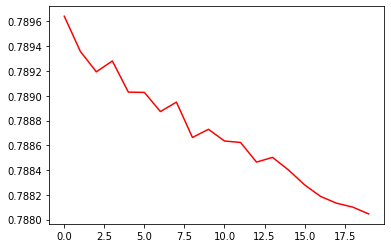

In [10]:
plt.plot(loss_list,color = 'r')
plt.savefig(model_path+"loss.png")

In [11]:
alphanet = alphanet.cpu()
pred_list = []
label_list = []
for _, (data, label) in enumerate(test_loader):
    data = Variable(data).float()
    pred = alphanet(data)
    pred_list.extend(pred.tolist())
    label_list.extend(label.tolist())

In [12]:
final = pd.DataFrame(pred_list)
final = pd.concat([target_list.reset_index(),final],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
# final.set_index(["timestamp","symbol"],inplace=True)
final

,timestamp,symbol,target,AlphaNet_Original_Input_10d_return
0,2021-01-04 09:30:00,1,2.080068,0.045161
1,2021-01-05 09:30:00,1,2.542624,0.051653
2,2021-01-06 09:30:00,1,2.731188,0.033233
3,2021-01-07 09:30:00,1,1.487784,-0.048123
4,2021-01-08 09:30:00,1,0.894896,-0.064707
...,...,...,...,...
402675,2021-05-25 09:30:00,688981,-0.262939,-0.269232
402676,2021-05-26 09:30:00,688981,-0.222002,-0.203154
402677,2021-05-27 09:30:00,688981,-0.212631,-0.614140
402678,2021-05-28 09:30:00,688981,-0.232948,-0.408152


In [14]:
final.to_parquet(output_path
                + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1])